In [24]:
import xarray as xr
import cartopy.crs as ccrs

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from pcv.io import majority_class_1_landuse, read_clim_mask, get_climate_shape_feature
from pcv.process import select_data
from pcv.process import mask_crop_forest

In [25]:
t2m_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_t2m.nc"
tp_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_tp.nc"
ssrd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_ssrd.nc"
lai_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_lai.nc"
swvlall_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_smroot.nc"
vpd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_vpd.nc"
sd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_sd.nc"

t2m_data = xr.open_dataset(t2m_path)
tp_data = xr.open_dataset(tp_path)
ssrd_data = xr.open_dataset(ssrd_path)
swvlall_data = xr.open_dataset(swvlall_path).rename({"lat":"latitude", "lon":"longitude"})
vpd_data = xr.open_dataset(vpd_path)
sd_data = xr.open_dataset(sd_path)
lai_data = xr.open_dataset(lai_path).rename({"lat":"latitude", "lon":"longitude"})
# lai_data = lai_data.reindex(lat = list(reversed(lai_data.latitude)))

In [34]:
t2m_winter = select_data(t2m_data,  "winter")
t2m_spring = select_data(t2m_data,  "spring")
t2m_summer = select_data(t2m_data,  "summer")

tp_winter = select_data(tp_data,  "winter")
tp_spring = select_data(tp_data,  "spring")
tp_summer = select_data(tp_data,  "summer")

ssrd_winter = select_data(ssrd_data,  "winter")
ssrd_spring = select_data(ssrd_data,  "spring")
ssrd_summer = select_data(ssrd_data,  "summer")

lai_winter = select_data(lai_data,  "winter")
lai_spring = select_data(lai_data,  "spring")
lai_summer = select_data(lai_data,  "summer")

swvlall_winter = select_data(swvlall_data,  "winter")
swvlall_spring = select_data(swvlall_data,  "spring")
swvlall_summer = select_data(swvlall_data,  "summer")

vpd_winter = select_data(vpd_data,  "winter")
vpd_spring = select_data(vpd_data,  "spring")
vpd_summer = select_data(vpd_data,  "summer")

sd_winter = select_data(sd_data,  "winter")
sd_spring = select_data(sd_data,  "spring")
sd_summer = select_data(sd_data,  "summer")

xtreme = "low"
if xtreme=="low":
    t = lai_summer.quantile(0.1, dim="time")
    lai_summer = xr.where(lai_summer<t, 1, 0)
elif xtreme == "high":
    t = lai_summer.quantile(0.9, dim="time")
    lai_summer = xr.where(lai_summer>t, 1, 0)


/home/anand/.conda/envs/pcv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [35]:
lat = lai_data.latitude.data
lon = lai_data.longitude.data

In [36]:
lu_mc_1 = majority_class_1_landuse(lon=lon, lat=lat)
mask_crop, mask_forest = mask_crop_forest(lu_mc_1)

In [37]:
shape_feature_list = get_climate_shape_feature()

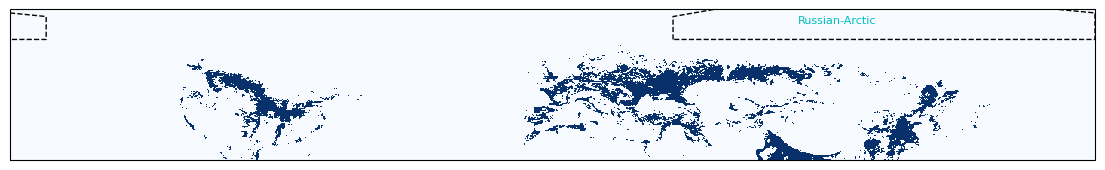

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8), 
                subplot_kw={'projection': ccrs.PlateCarree()})

ax.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), mask_crop, snap=True, cmap = "Blues")

for name, shape_feature, centroid in shape_feature_list:
    # if 75>centroid[1]>15:
    if name in ["Russian-Arctic"]: #["W.C.Asia", "E.C.Asia", "W.Siberia", "Tibetan-Plateau"]: 
        ax.add_feature(shape_feature, linestyle = "--", label = name)
        ax.set_extent((-180, 180, 25, 75), crs=ccrs.PlateCarree())
        ax.text(centroid[0], centroid[1], name, color='c', size=8, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())

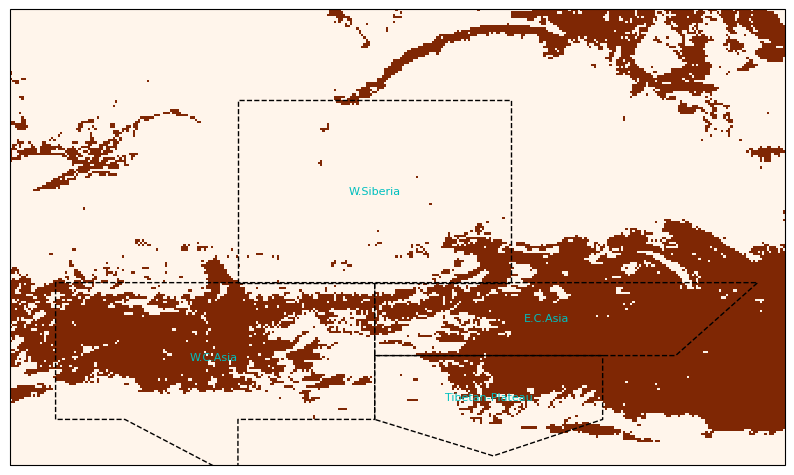

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8), 
                subplot_kw={'projection': ccrs.PlateCarree()})

ax.pcolormesh(np.linspace(-180, 180, 1441),np.linspace(25,75, 201), np.flip(mask_forest, axis=0), snap=True, cmap = "Oranges")

for name, shape_feature, centroid in shape_feature_list:
    # if 75>centroid[1]>15:
    if name in ["W.C.Asia", "E.C.Asia", "W.Siberia", "Tibetan-Plateau"]: 
        ax.add_feature(shape_feature, linestyle = "--", label = name)
        ax.set_extent((35, 120, 25, 75), crs=ccrs.PlateCarree())
        ax.text(centroid[0], centroid[1], name, color='c', size=8, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())

In [40]:
def filter_groups(var, region_mask, mask_forest, mask_crop, winter=False):    

    r_crop = np.flip(np.logical_and(region_mask, mask_crop), axis=0)
    r_forest = np.flip(np.logical_and(region_mask, mask_forest), axis=0)

    crop_regions = var.where(r_crop==True).stack(pixel=("latitude", "longitude")).dropna("pixel", how="all").unstack("pixel")
    forest_regions = var.where(r_forest==True).stack(pixel=("latitude", "longitude")).dropna("pixel", how="all").unstack("pixel")
    
    if winter:
        base_year = 1970+1
    else:
        base_year = 1970
    crop_regions.coords["time"] = [time.astype('datetime64[Y]').astype(int) + base_year for time in crop_regions.time.values]
    forest_regions.coords["time"] = [time.astype('datetime64[Y]').astype(int) + base_year for time in forest_regions.time.values]

    return crop_regions, forest_regions

In [41]:
ds_path = "/data/compoundx/anand/PCV/data/"
version = 0

for i, (region_mask, name) in enumerate(zip(*read_clim_mask())):
    
    t2m_w_crop, t2m_w_forest = filter_groups(t2m_winter, region_mask, mask_crop=mask_crop, mask_forest = mask_forest, winter=True)


    t2m_sp_crop, t2m_sp_forest = filter_groups(t2m_spring, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    t2m_su_crop, t2m_su_forest = filter_groups(t2m_summer, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)

    tp_w_crop, tp_w_forest = filter_groups(tp_winter, region_mask, mask_crop=mask_crop, mask_forest = mask_forest, winter=True)
    tp_sp_crop, tp_sp_forest = filter_groups(tp_spring, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    tp_su_crop, tp_su_forest = filter_groups(tp_summer, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)

    sm_w_crop, sm_w_forest = filter_groups(swvlall_winter, region_mask, mask_crop=mask_crop, mask_forest = mask_forest, winter=True)
    sm_sp_crop, sm_sp_forest = filter_groups(swvlall_spring, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    sm_su_crop, sm_su_forest = filter_groups(swvlall_summer, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    
    sd_w_crop, sd_w_forest = filter_groups(sd_winter, region_mask, mask_crop=mask_crop, mask_forest = mask_forest, winter=True)
    sd_sp_crop, sd_sp_forest = filter_groups(sd_spring, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    sd_su_crop, sd_su_forest = filter_groups(sd_summer, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    
    lai_w_crop, lai_w_forest = filter_groups(lai_winter, region_mask, mask_crop=mask_crop, mask_forest = mask_forest, winter=True)
    lai_sp_crop, lai_sp_forest = filter_groups(lai_spring, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
    lai_su_crop, lai_su_forest = filter_groups(lai_summer, region_mask, mask_crop=mask_crop, mask_forest = mask_forest)
  
    x_crop = xr.Dataset({
        "t2m_w_crop": t2m_w_crop, 
        "tp_w_crop": tp_w_crop, 
        "sm_w_crop": sm_w_crop, 
        "sd_w_crop": sd_w_crop, 
        "t2m_sp_crop": t2m_sp_crop, 
        "tp_sp_crop": tp_sp_crop, 
        "sm_sp_crop": sm_sp_crop, 
        "sd_sp_crop": sd_sp_crop, 
        "lai_sp_crop": lai_sp_crop, 
        "t2m_su_crop": t2m_sp_crop, 
        "tp_su_crop": tp_su_crop, 
        "sm_su_crop": sm_su_crop, 
        "sd_su_crop": sd_su_crop, 
        "lai_su_crop": lai_su_crop
    })

    x_forest = xr.Dataset({
        "t2m_w_forest": t2m_w_forest, 
        "tp_w_forest": tp_w_forest,
        "sm_w_forest": sm_w_forest, 
        "sd_w_forest": sd_w_forest,
        "t2m_sp_forest": t2m_sp_forest,
        "tp_sp_forest": tp_sp_forest,
        "sm_sp_forest": sm_sp_forest,
        "sd_sp_forest": sd_sp_forest,
        "lai_sp_forest": lai_sp_forest,
        "t2m_su_forest": t2m_sp_forest,
        "tp_su_forest": tp_su_forest,
        "sm_su_forest": sm_su_forest,
        "sd_su_forest": sd_su_forest, 
        "lai_su_forest": lai_su_forest,
    })

    print(name)
    if x_forest.longitude.shape[0] != 0:
        print(f"Total pixel: {np.sum(region_mask)}")
        x_forest.to_netcdf(f"{ds_path}forest_data/{xtreme}/"+f"forest_{name[:-4]}_v{version}.nc")
        n_forest = x_forest.latitude.values.shape[0]*x_forest.longitude.values.shape[0] -  np.isnan(x_forest.t2m_w_forest).mean("time").sum().values 
        print(f"Forest frac: {n_forest/np.sum(region_mask)*100:.2f}")

    if x_crop.longitude.shape[0] != 0:
        print(f"Total pixel: {np.sum(region_mask)}")
        x_crop.to_netcdf(f"{ds_path}crop_data/{xtreme}/"+f"crop_{name[:-4]}_v{version}.nc")
        n_crop = x_crop.latitude.values.shape[0]*x_crop.longitude.values.shape[0] -  np.isnan(x_crop.t2m_w_crop).mean("time").sum().values 
        print(f"Crop frac: {n_crop/np.sum(region_mask)*100:.2f}")


Equatorial.Pacific-Ocean.npy
S.Atlantic-Ocean.npy
E.Southern-Africa.npy
Greenland|Iceland.npy
W.North-America.npy
Total pixel: 5522
Forest frac: 30.91
Total pixel: 5522
Crop frac: 6.63
E.Siberia.npy
Total pixel: 12800
Forest frac: 72.09
Total pixel: 12800
Crop frac: 4.60
S.E.Asia.npy
S.South-America.npy
Southern-Ocean.npy
Tibetan-Plateau.npy
Total pixel: 3600
Forest frac: 11.08
Total pixel: 3600
Crop frac: 4.58
Central-Africa.npy
Russian-Arctic.npy
Total pixel: 23589
Forest frac: 26.68
West&Central-Europe.npy
Total pixel: 7720
Forest frac: 26.26
Total pixel: 7720
Crop frac: 52.16
Bay-of-Bengal.npy
E.Australia.npy
N.Atlantic-Ocean.npy
N.E.South-America.npy
E.Asia.npy
Total pixel: 11846
Forest frac: 22.98
Total pixel: 11846
Crop frac: 20.85
Arctic-Ocean.npy
S.Pacific-Ocean.npy
N.Central-America.npy
Total pixel: 2876
Forest frac: 11.54
Total pixel: 2876
Crop frac: 3.55
Mediterranean.npy
Total pixel: 12000
Forest frac: 12.35
Total pixel: 12000
Crop frac: 16.65
N.Eastern-Africa.npy
N.Europe